# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise`中，
我们发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。
同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。
本节如在 :numref:`sec_softmax_scratch`中一样，
继续使用Fashion-MNIST数据集，并保持批量大小为256。


In [1]:
import torch
from torch import nn
from myd2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax`所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。


In [3]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

“全局对应图”

| 手写的                    |  nn 代码                |
| ------------------------- | ------------------------- |
| `W, b`                    | `nn.Linear.weight / bias` |
| `X.reshape(-1, 784)`      | `nn.Flatten()`            |
| `X @ W + b`               | `nn.Linear(784, 10)`      |
| `softmax + cross_entropy` | `CrossEntropyLoss`（内部完成）  |
| `net(X)`                  | `nn.Module.__call__`      |
| 手动反向传播                    | `loss.backward()`         |
| 手动 SGD                    | `trainer.step()`          |

定义模型（这一行是核心）

```python
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
```

这是你之前 **几十行代码的浓缩版**。

---

1. `nn.Sequential`

```python
nn.Sequential(layer1, layer2, ...)
```
它是

* 一个 **容器模块（container module）**
* 本身是 `nn.Module`
* 按顺序调用内部层

等价于：

```python
def net(X):
    X = layer1(X)
    X = layer2(X)
    return X
```

特点

* 自动注册参数
* 自动支持 `.to(device)`
* 自动支持 `.parameters()`

**这是 PyTorch 模块化的核心设计之一**

---

2. `nn.Flatten()`

```python
nn.Flatten()
```

它把输入从：

```text
(batch_size, 1, 28, 28)
```

变成：

```text
(batch_size, 784)
```

等价于你之前写的：

```python
X.reshape((-1, 784))
```
为什么要有它？

> PyTorch **不会隐式 reshape**
> 所以必须明确告诉网络“这里我要拉平”

---

3. `nn.Linear(784, 10)`

```python
nn.Linear(in_features=784, out_features=10)
```
它内部等价于：

```python
self.weight = nn.Parameter(torch.randn(10, 784))
self.bias   = nn.Parameter(torch.zeros(10))
```

前向传播是：

```python
Y = X @ W.T + b
```

⚠️ 注意：
PyTorch 的 `Linear` 权重是 `(out, in)`，不是 `(in, out)`


---

4.初始化权重（和你手写版完全对齐）

```python
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
```

这里的 `m` 是什么？

* `net.apply(init_weights)` 会**递归遍历**
* 把每一个子模块传给 `init_weights`

遍历顺序：

```text
nn.Sequential
 ├── nn.Flatten
 └── nn.Linear  ← 命中
```

---

5. `nn.init.normal_`

```python
nn.init.normal_(tensor, std=0.01)
```

* 原地初始化（`_` 结尾）
* 均值 = 0
* 标准差 = 0.01

👉 **完全等价于你之前写的：**

```python
W = torch.normal(0, 0.01, size=(784, 10))
```

---

6. 应用初始化

```python
net.apply(init_weights)
```

* DFS 遍历整个模型
* 对每个子模块调用 `init_weights(m)`

👉 这是 **PyTorch 标准的初始化方式**


## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch`的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [4]:
loss = nn.CrossEntropyLoss(reduction='none')

 损失函数（这是一个“高级封装”的重点）

```python
loss = nn.CrossEntropyLoss(reduction='none')
```

这一行非常关键 
它等价于

```python
softmax
→ log
→ 取正确类别
→ 求负号
```

但 **它是 fused 的**：

```text
log-softmax + NLLLoss
```

---

参数解释

1. `reduction='none'`

* `'none'`：返回每个样本的 loss
* `'mean'`：返回 batch 平均
* `'sum'`：返回 batch 总和

d2l 的训练循环里会手动 `.mean()` / `.sum()`
所以这里必须用 `'none'`

---

输入 / 输出约定（非常重要）

```python
loss(y_hat, y)
```

* `y_hat`: **raw logits**（不能 softmax！）
* `y`: 类别索引（int）

⚠️ **这就是为什么 net 没有 softmax**

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [5]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

训练（最后的“魔法”）

```python
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
```

这里发生了什么？

`train_ch3` 内部会：

1. `net.train()`
2. for epoch:

   * for batch:

     * `y_hat = net(X)`
     * `l = loss(y_hat, y)`
     * `l.mean().backward()`
     * `trainer.step()`
3. 评估 test accuracy
4. 画图

---

`trainer` 

```python
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
```

它替你做了：

* 梯度管理
* 参数更新
* state 管理

👉 **你之前手写的 `d2l.sgd` 的高级版本**

---

## 三、最重要的一句话（理解 PyTorch 的关键）

> **PyTorch 的 nn 并没有“多做事”
> 它只是把你已经写过的正确逻辑，
> 用“约定 + 抽象”封装起来了**


## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


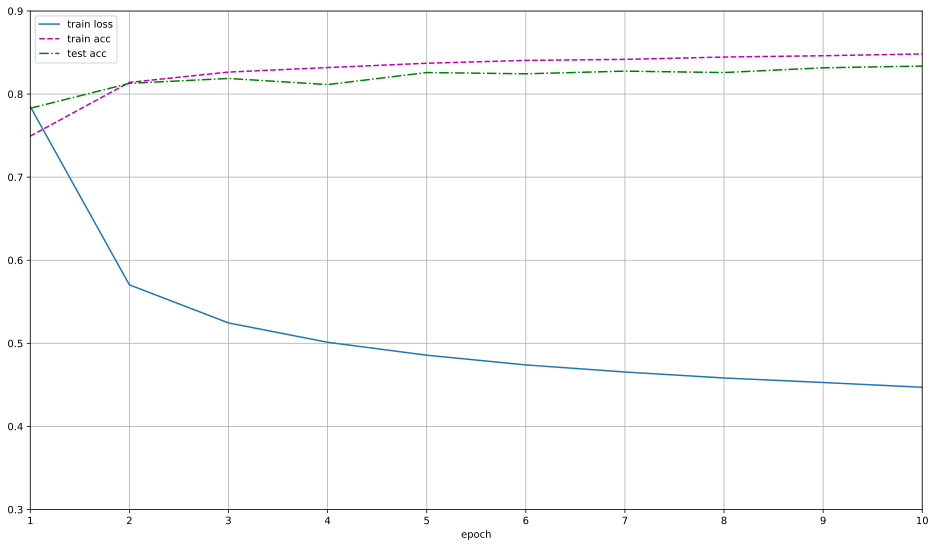

In [6]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？


[Discussions](https://discuss.d2l.ai/t/1793)
